# Spatial Localisation using SNNs

### Environment setup

In [2]:
import keras 
from keras import regularizers
from keras.layers import SimpleRNN, Dense, GaussianNoise
from keras.models import Sequential, load_model
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
T         = 10    # total time to simulate (msec)
dt        = 0.0125 # Simulation timestep
time      = int(T / dt)
inpt      = 1.0   # Neuron input voltage
neuron_input=np.full((time),inpt)

### Utilities

In [5]:
def plot_neuron_behaviour(time, data, neuron_type, neuron_id, y_title):
    #print ('Drawing graph with time.shape={}, data.shape={}'.format(time.shape, data.shape))
    plt.plot(time,data)
    plt.title('{} @ {}'.format(neuron_type, neuron_id))
    plt.ylabel(y_title)
    plt.xlabel('Time (msec)')
    # Graph to the data with some headroom...
    y_min = 0
    y_max = max(data)*1.2
    if y_max == 0:
        y_max = 1
    plt.ylim([y_min,y_max])   
    plt.show()

In [6]:
def plot_membrane_potential(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Membrane potential (V)')

def plot_spikes(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Spike (V)')

### Data

In [7]:
input_set = np.load('/content/drive/My Drive/BTP/input_set.npy')


### LIF Neuron

[Code Reference](https://github.com/markstrefford/Spiking-Neural-Network)

In [8]:
class LIFNeuron():
    def __init__(self, debug=True):
        
        # Simulation config (may not all be needed!!)
        self.dt       = 0.125       # simulation time step
        self.t_rest   = 0           # initial refractory time
        
        #LIF Properties 
        self.Vm       = np.array([0])    # Neuron potential (mV)
        self.time     = np.array([0])    # Time duration for the neuron (needed?)
        self.spikes   = np.array([0])    # Output (spikes) for the neuron

        #self.output   = 0               # Neuron output
        self.t        = 0                # Neuron time step
        self.Rm       = 1                # Resistance (kOhm)
        self.Cm       = 10               # Capacitance (uF) 
        self.tau_m    = self.Rm * self.Cm # Time constant
        self.tau_ref  = 4                # refractory period (ms)
        self.Vth      = 0.75             # = 1  #spike threshold
        self.V_spike  = 1                # spike delta (V)
        self.type     = 'Leaky Integrate and Fire'
        self.debug    = debug
        if self.debug:
            print ('LIFNeuron(): Created {} neuron starting at time {}'.format(self.type, self.t))
    
    def spike_generator(self, neuron_input):
        # Create local arrays for this run
        duration = len(neuron_input)
        Vm = np.zeros(duration)  #len(time)) # potential (V) trace over time
        time = np.arange(self.t, self.t+duration)       
        spikes = np.zeros(duration)  #len(time))
        
        if self.debug:
            print ('spike_generator(): Running time period self.t={}, self.t+duration={}'
                   .format(self.t, self.t+duration))
        
        # Seed the new array with previous value of last run
        Vm[-1] = self.Vm[-1]
        
        if self.debug:
            print ('LIFNeuron.spike_generator.initial_state(input={}, duration={}, initial Vm={}, t={})'
               .format(neuron_input, duration, Vm[-1], self.t))
            
        for i in range(duration):
            if self.debug:
                print ('Index {}'.format(i))
                
            if self.t > self.t_rest:
                Vm[i]=Vm[i-1] + (-Vm[i-1] + neuron_input[i-1]*self.Rm) / self.tau_m * self.dt

                if self.debug:
                    print('spike_generator(): i={}, self.t={}, Vm[i]={}, neuron_input={}, self.Rm={}, self.tau_m * self.dt = {}'
                          .format(i,self.t, Vm[i], neuron_input[i], self.Rm, self.tau_m * self.dt))
                
                if Vm[i] >= self.Vth:
                    spikes[i] += self.V_spike
                    self.t_rest = self.t + self.tau_ref
                    if self.debug:
                        print ('*** LIFNeuron.spike_generator.spike=(self.t_rest={}, self.t={}, self.tau_ref={})'
                           .format(self.t_rest, self.t, self.tau_ref))

            self.t += self.dt
        
        # Save state
        self.Vm = np.append(self.Vm, Vm)
        self.spikes = np.append(self.spikes, spikes)
        self.time = np.append(self.time, time)
        
        if self.debug:
            print ('LIFNeuron.spike_generator.exit_state(Vm={} at iteration i={}, time={})'
                   .format(self.Vm, i, self.t))
        
        #return time, Vm, output

### Building a network

In [9]:
model = load_model('/content/drive/MyDrive/BTP/BTP-2/model_rect_50_10.h5')
weights = []

for layer in model.layers:
    weights.append(layer.get_weights())
    # print(len(weights))

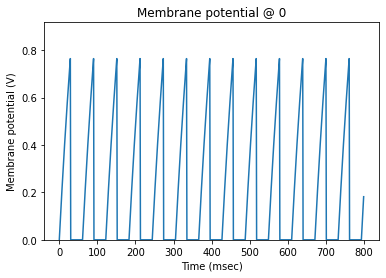

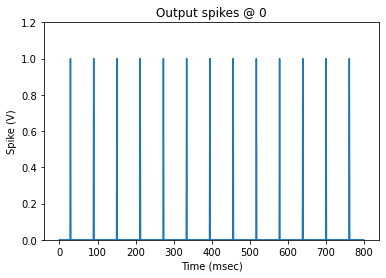

In [21]:
demo_input = np.full((time), 2.5)

demo_neuron = LIFNeuron(debug=False)
demo_neuron.spike_generator(demo_input)

plot_membrane_potential(demo_neuron.time, demo_neuron.Vm, 'Membrane potential')
plot_spikes(demo_neuron.time, demo_neuron.spikes, 'Output spikes')

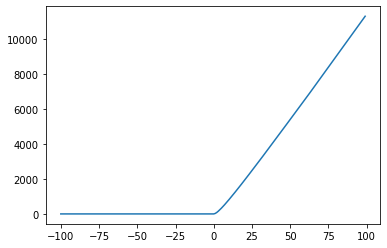

In [11]:
sample_neuron = LIFNeuron(debug=False)
spike_arr = []

for x in range(-100,100):
    sample_input = np.full((time), x)
    sample_neuron.spike_generator(sample_input)
    spike_arr.append(sum(sample_neuron.spikes))

plt.plot(list(range(-100,100)), spike_arr)

In [15]:
def create_neurons(num_layers, num_neurons, debug=True):
    neurons = []
    for layer in range(num_layers):
        if debug:
            print ('create_neurons(): Creating layer {}'.format(layer))
        neuron_layer = []
        for count in range(num_neurons[layer]):
            neuron_layer.append(LIFNeuron(debug=debug))
        neurons.append(neuron_layer)
    return neurons

In [17]:
num_layers = 4
num_neurons = [2,100,100,2]

In [18]:
snn = create_neurons(num_layers, num_neurons, debug=False)

In [ ]:
"""

0. Initialize prev_hidden_layer to zeros

In each input frame (duration T = N*dt viz. N time steps) - 
    1. Input (speed, direction) -> input_layer
    2. input_layer, prev_hidden_layer -> synaptic weights -> hidden_layer
    3. hidden_layer -> output_layer, prev_hidden_layer
    4. output_layer -> Output (x,y)

"""